In [1]:
import os
import re
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython import display
torch.manual_seed(69)
torch.set_printoptions(profile="short", sci_mode=False, linewidth=100000)
# this script is configured to run on a RTX 3060 12GB GPU. you'll want to adjust the model sizes and batch sizes for other devices
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 50
plt.rcParams['axes.grid'] = True
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True

# Data Prep

In [2]:
# we use this 40mb file of concatenated anime subtitles as our dataset
# just the right size for toy experiments like this I think
with open('animesubs.txt', 'r') as f:
    text = f.read()
print("length of dataset in characters: ", len(text))

length of dataset in characters:  39526018


In [3]:
print(text[:500])

Open your mind. Open your mind.

Far beyond the deep blue Earth, you and I shall meet...

AH! MY GODDESS

A snow-white feather comes fluttering down, swaying gently in the air.

Without holding back, I want to envelope you, my one and only love.

I know I have the power to protect the one I love, right here in my hands.

Open your mind. Just as I've always dreamed.

Let the wind carry off your hopes, faraway.

I have wings nobody can see. Look, you have them, too.

They'll take us to where we ca


In [4]:
# remove japanese characters
text = ''.join(filter(lambda character:ord(character) < 0x3000, text))

In [5]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("unique characters:", vocab_size, ''.join(chars))

unique characters: 86 
 !'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyz|”


In [6]:
# yes, all language models will be character level, which isn't ideal but it's good for simplicity
# very simple tokenizer
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
# add special token for padding
stoi[''] = len(stoi)
itos[len(itos)] = ''
print(stoi)
print(itos)
encode = lambda s: [stoi[ch] for ch in s]
decode = lambda l: ''.join([itos[i] for i in l])
print("encoded:", encode(text[:20]))
print("decoded:", decode(encode(text[:20])))
vocab_size = len(itos)
print("vocab size:", vocab_size)

{'\n': 0, ' ': 1, '!': 2, "'": 3, '(': 4, ')': 5, '*': 6, '+': 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, ';': 23, '<': 24, '=': 25, '>': 26, '?': 27, '@': 28, 'A': 29, 'B': 30, 'C': 31, 'D': 32, 'E': 33, 'F': 34, 'G': 35, 'H': 36, 'I': 37, 'J': 38, 'K': 39, 'L': 40, 'M': 41, 'N': 42, 'O': 43, 'P': 44, 'Q': 45, 'R': 46, 'S': 47, 'T': 48, 'U': 49, 'V': 50, 'W': 51, 'X': 52, 'Y': 53, 'Z': 54, '[': 55, ']': 56, '_': 57, 'a': 58, 'b': 59, 'c': 60, 'd': 61, 'e': 62, 'f': 63, 'g': 64, 'h': 65, 'i': 66, 'j': 67, 'k': 68, 'l': 69, 'm': 70, 'n': 71, 'o': 72, 'p': 73, 'q': 74, 'r': 75, 's': 76, 't': 77, 'u': 78, 'v': 79, 'w': 80, 'x': 81, 'y': 82, 'z': 83, '|': 84, '”': 85, '': 86}
{0: '\n', 1: ' ', 2: '!', 3: "'", 4: '(', 5: ')', 6: '*', 7: '+', 8: ',', 9: '-', 10: '.', 11: '/', 12: '0', 13: '1', 14: '2', 15: '3', 16: '4', 17: '5', 18: '6', 19: '7', 20: '8', 21: '9', 22: ':', 23: ';', 24: '<', 25: '=', 

In [7]:
data = torch.tensor(encode(text), dtype=torch.int64)
data.shape

torch.Size([39526018])

In [8]:
data[:100]

tensor([43, 73, 62, 71,  1, 82, 72, 78, 75,  1, 70, 66, 71, 61, 10,  1, 43, 73, 62, 71,  1, 82, 72, 78, 75,  1, 70, 66, 71, 61, 10,  0,  0, 34, 58, 75,  1, 59, 62, 82, 72, 71, 61,  1, 77, 65, 62,  1, 61, 62, 62, 73,  1, 59, 69, 78, 62,  1, 33, 58, 75, 77, 65,  8,  1, 82, 72, 78,  1, 58, 71, 61,  1, 37,  1, 76, 65, 58, 69, 69,  1, 70, 62, 62, 77, 10, 10, 10,  0,  0, 29, 36,  2,  1, 41, 53,  1, 35, 43, 32])

In [9]:
n = int(len(data) * 0.99)
train_data = data[:n]
val_data = data[n:]
print(train_data.shape, val_data.shape)

torch.Size([39130757]) torch.Size([395261])


In [10]:
seq_len = 8
train_data[:seq_len+1]

tensor([43, 73, 62, 71,  1, 82, 72, 78, 75])

In [11]:
def get_batch(split, seq_len, batch_size=4):
    # generate a small batch of data of inputs x and targets y
    # targets are just inputs shifted by 1
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - seq_len, (batch_size,))
    x = torch.stack([data[i:i+seq_len] for i in ix])
    y = torch.stack([data[i+1:i+seq_len+1] for i in ix])
    return x.to(device), y.to(device)

xb, yb = get_batch('train', 64, 2)
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

inputs:
torch.Size([2, 64])
tensor([[64,  1, 72, 78, 75,  1, 66, 71, 77, 62, 75, 71, 76, 65, 66, 73, 76, 10,  0,  0, 48, 65, 62,  1, 71, 66, 64, 65, 77,  1, 37, 66, 61, 58,  1, 64, 72, 77,  1, 77, 65, 62,  1, 75, 62, 76, 78, 69, 77, 76,  1, 72, 63,  1, 77, 65, 62,  1, 62, 81, 58, 70, 66, 71],
        [62, 70,  2,  0,  0, 37, 77,  1, 69, 72, 72, 68, 76,  1, 69, 66, 68, 62,  1, 80, 62,  1, 77, 72, 72, 68,  1, 60, 58, 75, 62,  1, 72, 63,  1, 77, 65, 62, 70, 10,  0,  0, 48, 65, 72, 76, 62,  1, 64, 78, 82, 76,  1, 80, 62, 75, 62,  1, 66, 71, 60, 75, 62, 61]], device='cuda:0')
targets:
torch.Size([2, 64])
tensor([[ 1, 72, 78, 75,  1, 66, 71, 77, 62, 75, 71, 76, 65, 66, 73, 76, 10,  0,  0, 48, 65, 62,  1, 71, 66, 64, 65, 77,  1, 37, 66, 61, 58,  1, 64, 72, 77,  1, 77, 65, 62,  1, 75, 62, 76, 78, 69, 77, 76,  1, 72, 63,  1, 77, 65, 62,  1, 62, 81, 58, 70, 66, 71, 58],
        [70,  2,  0,  0, 37, 77,  1, 69, 72, 72, 68, 76,  1, 69, 66, 68, 62,  1, 80, 62,  1, 77, 72, 72, 68,  1, 60, 58, 75, 62

# Training Prep

In [12]:
# Make all steps, sequence lengths, and batch size the same
total_steps = 1250
seq_len = 128
batch_size = 512 # these are small models so we can use large batch sizes to fully utilize the GPU
# should cover around 2x the dataset
total_steps * seq_len * batch_size

81920000

In [13]:
def train(model, optimizer, seq_len, batch_size, total_steps, val_steps=10, val_interval=50):
    losses = []
    val_losses = []
    # live plot
    fig, ax = plt.subplots()
    dh = display.display(fig, display_id=True)
    for steps in (bar := tqdm(range(total_steps))):  # increase number of steps for good results...
        # sample a batch of data
        xb, yb = get_batch('train', seq_len=seq_len, batch_size=batch_size)

        # evaluate the loss
        logits, loss = model(xb, yb)

        # backprop
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        bar.set_description(f"loss: {loss.item():.2f}, val loss: {val_losses[-1] if val_losses else 0:.2f}")
        losses.append(loss.item())
        if steps % val_interval == 0:
            # Calculate validation loss
            with torch.no_grad():
                val_loss = 0
                for _ in range(val_steps):
                    xb, yb = get_batch('val', seq_len=seq_len, batch_size=batch_size)
                    _, loss = model(xb, yb)
                    val_loss += loss.item()
                val_loss /= val_steps
                val_losses.append(val_loss)
            ax.clear()
            ax.plot(losses, color='blue', label='train loss', alpha=0.7)
            ax.plot(range(0, len(losses), val_interval), val_losses, color='red', label='val loss', alpha=0.7)
            ax.set_ylim(1, 4)
            ax.legend()
            dh.update(fig)
    print('final loss:', loss.item(), 'final val loss:', val_loss)

# Bigram Model

In [ ]:
class BigramEmbedLM(nn.Module):
    def __init__(self, vocab_size, seq_len, embed_size):
        super().__init__()
        # embed raw tokens to a lower dimensional embedding with embed_size
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        # embed block sized context length as positional embeddings of the same size
        self.position_embedding_table = nn.Embedding(seq_len, embed_size)
        # Language Modelling (?) Head is a standard linear layer to go from 
        # embeddings back to logits of vocab_size
        self.lm_head = nn.Linear(embed_size, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        # idx and targets are both (B,T) tensor of integers
        tok_embd = self.token_embedding_table(idx) # (B,T,C)
        pos_embd = self.position_embedding_table(torch.arange(T).to(device)) # (T,C) [0...T-1]
        x = tok_embd + pos_embd
        logits = self.lm_head(x) # (B,T,C)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            #crop idx to the last seq_len tokens
            idx_context = idx[:, -seq_len:]
            # get the predictions
            logits, loss = self(idx_context)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

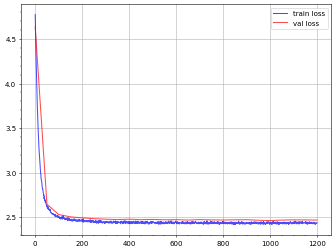

  0%|          | 0/1250 [00:00<?, ?it/s]

final loss: 2.431291103363037 final val loss: 2.465692067146301


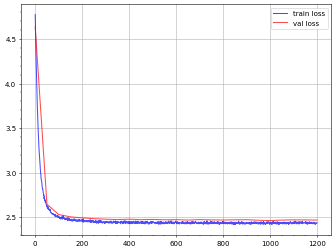

In [ ]:
# training!
model = BigramEmbedLM(vocab_size, seq_len, 64)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3)
train(model, optimizer, seq_len, batch_size, total_steps)

In [ ]:
# generate
# print(decode(m.generate(idx=torch.zeros((1, 1), dtype=torch.long), max_new_tokens=300)[0].tolist()))
model.eval()
idx = encode("You will never")
print(torch.tensor([idx]))
print(decode(model.generate(idx=torch.tensor([idx], dtype=torch.long).to(device), max_new_tokens=1000)[0].tolist()))

tensor([[53, 72, 78,  1, 80, 66, 69, 69,  1, 71, 62, 79, 62, 75]])
You will nevery libe phedontowin Fous be yonir ct!


Thad Maner elen I.

T ninos res. at t eikevs'r?


Itrithe 8redtrpokin,

So t usou!

Yid y gow o nPou'ry,

Whe pan ma I s horyo <Uube?
I wotom son magh on is mu it tey ed ee he gos isthaido f t Ritomathus!



W annghoicouyowit'nee why fo hiilo the Ejuthe ceth..?




Itonnc an! Dre Cac mede cou kinswou sero hemy Ex miwoho hitaks wat lilg tothiou Rfuping Telthendoo, fethaas laurafolseyon's hend!

The r tin oe o o heanen mingofirsonnoou've t Shomomat ct waundnn's Ma Whekous hes wd he beoousmo tite fe m e.

Even''spond!
Thow o t'ryen ho e m careabe pttokat tithird I an he!
Ithecyon!
I woud Ars cowiole, t serctis fus be f m. h es tle atofre t ous t y,
Whis weric i dee her?!
Maroyou oowho us t ly.

burd s w do ino the ndodo, mereleveouig CP, you sag athef fon lyoimak?


Thech?


I th1
Istitoree I m heanethasefomiseag an al, aincan ia t wheyoovecs

Nou r, f bl amangat hen wen

# Recurrent Models

## Classic RNN

In [ ]:
class RNNLayer(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        self.u = nn.Linear(embed_size, embed_size)
        self.w = nn.Linear(embed_size, embed_size)
        self.v = nn.Linear(embed_size, embed_size)

    def forward(self, x, h):
        h = torch.tanh(self.u(x) + self.v(h))
        out = self.w(h)
        return out, h
    
class RNNLM(nn.Module):
    def __init__(self, vocab_size, embed_size, layer_num):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        self.lm_head = nn.Linear(embed_size, vocab_size)
        self.rnn_layers = nn.ModuleList([RNNLayer(embed_size) for _ in range(layer_num)])

    def forward(self, idx, targets=None):
        # idx and targets are both (B,T) tensor of integers
        B, T = idx.shape
        x = self.token_embedding_table(idx)
        h = torch.zeros(B, self.embed_size, device=x.device)
        outs = []
        for t in range(T):
            o = x[:, t, :]
            for rnn_layer in self.rnn_layers:
                o, h = rnn_layer(o, h)
            outs.append(o)
        outs = torch.stack(outs, dim=1)
        logits = self.lm_head(outs)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, idx, max_new_tokens, temperature=1):
        # generate max_new_tokens new tokens given the initial context idx
        # idx is (B, T) array of indices in the current context
        B, T = idx.shape
        # because this is an RNN, we generate one token at a time with a hidden state
        h = torch.zeros(B, self.embed_size, device=idx.device)
        embeds = self.token_embedding_table(idx)
        # first, fill h by iterating through the context
        for t in range(T):
            o = embeds[:, t, :]
            for rnn_layer in self.rnn_layers:
                o, h = rnn_layer(o, h)
        # then, generate new tokens
        o = o.unsqueeze(1)
        for _ in range(max_new_tokens):
            for rnn_layer in self.rnn_layers:
                o, h = rnn_layer(o, h)
            logits = self.lm_head(o)
            logits = logits.squeeze(1)
            probs = F.softmax(logits / temperature, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1) if temperature > 0 else torch.argmax(probs, dim=-1, keepdim=True)
            idx = torch.cat((idx, idx_next), dim=1)
            o = self.token_embedding_table(idx_next)
        return idx

In [ ]:
# Test forward pass
torch.set_printoptions(profile="short", sci_mode=False, linewidth=100000)
m = RNNLM(vocab_size, 210, 4)
m.to(device)
xb, yb = get_batch('train', 32, 1)
logits, loss = m(xb, yb)
total_params = sum(p.numel() for p in m.parameters() if p.requires_grad)
total_params

568347

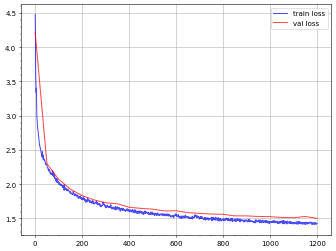

  0%|          | 0/1250 [00:00<?, ?it/s]

final loss: 1.4256839752197266 final val loss: 1.5008117318153382


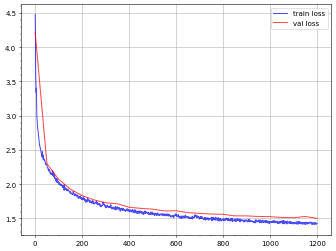

In [ ]:
# training!
model = RNNLM(vocab_size, 210, 4)
model.to(device)
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
train(model, optimizer, seq_len, batch_size, total_steps)

In [ ]:
# Save
torch.save(model.state_dict(), 'RNNLM.pt')

In [ ]:
# Load model
model = RNNLM(vocab_size, 210, 4)
model.load_state_dict(torch.load('RNNLM.pt'))
model.to(device)

RNNLM(
  (token_embedding_table): Embedding(87, 210)
  (lm_head): Linear(in_features=210, out_features=87, bias=True)
  (rnn_layers): ModuleList(
    (0-3): 4 x RNNLayer(
      (u): Linear(in_features=210, out_features=210, bias=True)
      (w): Linear(in_features=210, out_features=210, bias=True)
      (v): Linear(in_features=210, out_features=210, bias=True)
    )
  )
)

In [ ]:
model.eval()
idx = encode("You will never")
print(torch.tensor([idx]))
print(decode(model.generate(idx=torch.tensor([idx], dtype=torch.long).to(device), temperature=0.5, max_new_tokens=1000)[0].tolist()))


tensor([[53, 72, 78,  1, 80, 66, 69, 69,  1, 71, 62, 79, 62, 75]])
You will neveressing and think the ground of the possinested into a single stronger to the fature to say the strong to pretty.

That is the same to be all of see me?

I was a battle on me in the same that this study after the course about the can the probably get it.

What's the really become for you become anymorrow when it was a good after them to have to be we can't say.

I want to actually seems and this way the side a little is as the away to the second the since the think then I want to contration.

I want to be a dishing to be chot of the first same to heard for a bad them in a mount.

In the fates are you canta will seems are you can finally think he want to the because it's a come on you.

What are you think they're become out something the first time.

That's the day that before the time for the store, the store we don't be only the play to be a guys are you going in the most of the found to do than the day tw

## GRU

In [ ]:
class GRULayer(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        self.u = nn.Linear(embed_size, embed_size)
        self.w = nn.Linear(embed_size, embed_size)
        self.r = nn.Linear(embed_size, embed_size)
        self.v = nn.Linear(embed_size, embed_size)

    def forward(self, x, h):
        r = torch.sigmoid(self.r(x) + self.v(h))
        z = torch.sigmoid(self.u(x) + self.w(h))
        h_tilde = torch.tanh(self.u(x) + r * self.w(h))
        h = (1 - z) * h_tilde + z * h
        return h, h
    
class GRULM(nn.Module):
    def __init__(self, vocab_size, embed_size, layer_num):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        self.lm_head = nn.Linear(embed_size, vocab_size)
        self.rnn_layers = nn.ModuleList([GRULayer(embed_size) for _ in range(layer_num)])

    def forward(self, idx, targets=None):
        # idx and targets are both (B,T) tensor of integers
        B, T = idx.shape
        x = self.token_embedding_table(idx)
        h = torch.zeros(B, self.embed_size, device=x.device)
        outs = []
        for t in range(T):
            o = x[:, t, :]
            for rnn_layer in self.rnn_layers:
                o, h = rnn_layer(o, h)
            outs.append(o)
        outs = torch.stack(outs, dim=1)
        logits = self.lm_head(outs)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, idx, max_new_tokens, temperature=1):
        # generate max_new_tokens new tokens given the initial context idx
        # idx is (B, T) array of indices in the current context
        B, T = idx.shape
        # because this is an RNN, we generate one token at a time with a hidden state
        h = torch.zeros(B, self.embed_size, device=idx.device)
        embeds = self.token_embedding_table(idx)
        # first, fill h by iterating through the context
        for t in range(T):
            o = embeds[:, t, :]
            for rnn_layer in self.rnn_layers:
                o, h = rnn_layer(o, h)
        # then, generate new tokens
        o = o.unsqueeze(1)
        for _ in range(max_new_tokens):
            for rnn_layer in self.rnn_layers:
                o, h = rnn_layer(o, h)
            logits = self.lm_head(o)
            logits = logits.squeeze(1)
            probs = F.softmax(logits / temperature, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1) if temperature > 0 else torch.argmax(probs, dim=-1, keepdim=True)
            idx = torch.cat((idx, idx_next), dim=1)
            o = self.token_embedding_table(idx_next)
        return idx

In [ ]:
# Test forward pass
m = GRULM(vocab_size, 182, 4)
m.to(device)
xb, yb = get_batch('train', 32, 4)
logits, loss = m(xb, yb)
total_params = sum(p.numel() for p in m.parameters() if p.requires_grad)
total_params

564651

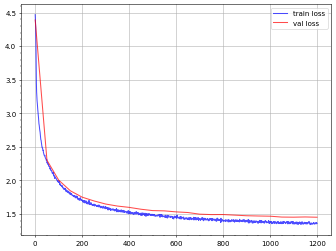

  0%|          | 0/1250 [00:00<?, ?it/s]

final loss: 1.353551983833313 final val loss: 1.4514727354049684


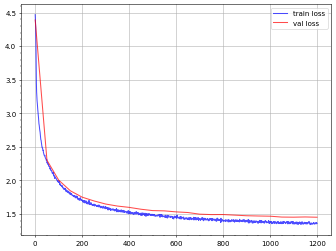

In [ ]:
# training!
model = GRULM(vocab_size, 182, 4)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
train(model, optimizer, seq_len, batch_size, total_steps)

In [ ]:
# Save
torch.save(model.state_dict(), 'GRULM.pt')

In [ ]:
# Load model
model = GRULM(vocab_size, 182, 4)
model.load_state_dict(torch.load('GRULM.pt'))
model.to(device)

GRULM(
  (token_embedding_table): Embedding(87, 182)
  (lm_head): Linear(in_features=182, out_features=87, bias=True)
  (rnn_layers): ModuleList(
    (0-3): 4 x GRULayer(
      (u): Linear(in_features=182, out_features=182, bias=True)
      (w): Linear(in_features=182, out_features=182, bias=True)
      (r): Linear(in_features=182, out_features=182, bias=True)
      (v): Linear(in_features=182, out_features=182, bias=True)
    )
  )
)

In [ ]:
model.eval()
idx = encode("You will never")
print(torch.tensor([idx]))
print(decode(model.generate(idx=torch.tensor([idx], dtype=torch.long).to(device), temperature=0.5, max_new_tokens=1000)[0].tolist()))

tensor([[53, 72, 78,  1, 80, 66, 69, 69,  1, 71, 62, 79, 62, 75]])
You will never match that you were been dead.

I'm still wait all all this school.

You love me to lose...

A students to continue my father.

I don't see the children, so I leaving her official.

What the fate and Don't be a choice of you to go on a little place and confessed the ends.

If you end that can be having the party.

I thought you go of the enemy as a man is a little talent.

It's not going to end that you're going to make the same instead of your point and real problem to protect him.

What are you still look at me.

I wonder if you might not take it to the same sleep.

What about everything are one pretty fate of your friends.

It was the sense of his spirit and being a bring past on the student of the brother.

Why are you stay to meet me.

We really still be that something to contact the room...

The captain was one of the stars.

It can did it going about this for starting starting at something to make 

# LSTM

In [14]:
class LSTMLayer(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        self.u = nn.Linear(embed_size, embed_size)
        self.w = nn.Linear(embed_size, embed_size)
        self.f = nn.Linear(embed_size, embed_size)
        self.i = nn.Linear(embed_size, embed_size)
        self.o = nn.Linear(embed_size, embed_size)
        self.v = nn.Linear(embed_size, embed_size)

    def forward(self, x, h, c):
        f = torch.sigmoid(self.f(x) + self.v(h))
        i = torch.sigmoid(self.i(x) + self.v(h))
        o = torch.sigmoid(self.o(x) + self.v(h))
        c_tilde = torch.tanh(self.u(x) + self.w(h))
        c = f * c + i * c_tilde
        h = o * torch.tanh(c)
        return h, c

class LSTMLM(nn.Module):
    def __init__(self, vocab_size, embed_size, layer_num):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        self.lm_head = nn.Linear(embed_size, vocab_size)
        self.rnn_layers = nn.ModuleList([LSTMLayer(embed_size) for _ in range(layer_num)])

    def forward(self, idx, targets=None):
        # idx and targets are both (B,T) tensor of integers
        B, T = idx.shape
        x = self.token_embedding_table(idx)
        h = torch.zeros(B, self.embed_size, device=x.device)
        c = torch.zeros(B, self.embed_size, device=x.device)
        outs = []
        for t in range(T):
            o = x[:, t, :]
            for rnn_layer in self.rnn_layers:
                h, c = rnn_layer(o, h, c)
            outs.append(h)
        outs = torch.stack(outs, dim=1)
        logits = self.lm_head(outs)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, idx, max_new_tokens, temperature=1):
        # generate max_new_tokens new tokens given the initial context idx
        # idx is (B, T) array of indices in the current context
        B, T = idx.shape
        # because this is an RNN, we generate one token at a time with a hidden state
        h = torch.zeros(B, self.embed_size, device=idx.device)
        c = torch.zeros(B, self.embed_size, device=idx.device)
        embeds = self.token_embedding_table(idx)
        # first, fill h by iterating through the context
        for t in range(T):
            o = embeds[:, t, :]
            for rnn_layer in self.rnn_layers:
                h, c = rnn_layer(o, h, c)
        # then, generate new tokens
        o = o.unsqueeze(1)
        for _ in range(max_new_tokens):
            for rnn_layer in self.rnn_layers:
                h, c = rnn_layer(o, h, c)
            logits = self.lm_head(h)
            logits = logits.squeeze(1)
            probs = F.softmax(logits / temperature, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1) if temperature > 0 else torch.argmax(probs, dim=-1, keepdim=True)
            idx = torch.cat((idx, idx_next), dim=1)
            o = self.token_embedding_table(idx_next)
        return idx

In [29]:
# Test forward pass
m = LSTMLM(vocab_size, 128, 4)
m.to(device)
xb, yb = get_batch('train', 32, 4)
logits, loss = m(xb, yb)
total_params = sum(p.numel() for p in m.parameters() if p.requires_grad)
total_params

418647

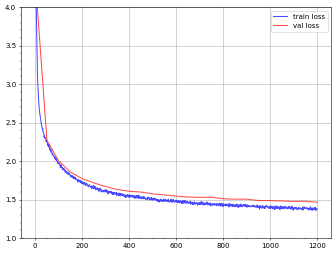

  0%|          | 0/1250 [00:00<?, ?it/s]

final loss: 1.3692666292190552 final val loss: 1.4661073327064513


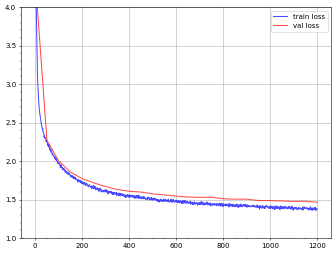

In [31]:
# training!
model = LSTMLM(vocab_size, 132, 4)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
train(model, optimizer, seq_len, batch_size, total_steps)

In [32]:
# Save
torch.save(model.state_dict(), 'LSTMLM.pt')

In [15]:
# Load model
model = LSTMLM(vocab_size, 132, 4)
model.load_state_dict(torch.load('LSTMLM.pt'))
model.to(device)

LSTMLM(
  (token_embedding_table): Embedding(87, 132)
  (lm_head): Linear(in_features=132, out_features=87, bias=True)
  (rnn_layers): ModuleList(
    (0-3): 4 x LSTMLayer(
      (u): Linear(in_features=132, out_features=132, bias=True)
      (w): Linear(in_features=132, out_features=132, bias=True)
      (f): Linear(in_features=132, out_features=132, bias=True)
      (i): Linear(in_features=132, out_features=132, bias=True)
      (o): Linear(in_features=132, out_features=132, bias=True)
      (v): Linear(in_features=132, out_features=132, bias=True)
    )
  )
)

In [16]:
# generate
model.eval()
idx = encode("You will never")
print(torch.tensor([idx]))
print(decode(model.generate(idx=torch.tensor([idx], dtype=torch.long).to(device), temperature=0.5, max_new_tokens=1000)[0].tolist())
)

tensor([[53, 72, 78,  1, 80, 66, 69, 69,  1, 71, 62, 79, 62, 75]])
You will nevery the way to the school and of the world.

I don't let you a with you to the enterstand of right now, right?

It's a super of the one who was all in past with a father about the same with the city of the same empty of the same company as the way to punish off the way before you can have a bit problems...

It's a big sound matter!

And what do you know what the same way to go on together for the power, right?

I think she doesn't go on the woman of the one with a way to the started me anything because of the shock down in our first for me!

He was so many town the second enemy and the top the problem, huh?

It's your second of the same students.

I'm sure you were leaving a rest a lot of a while is a little back out of the course of the second in the new more of the pictures, the person then the man isn't a super is only too working at the super is a face, and a fight with him so much can get my particular 

# RWKV-1 (Peng et al., 2023)

In [ ]:
class RWKVBlock(nn.Module):
    def __init__(self, embed_size, heads):
        super().__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.u = nn.Linear(embed_size, embed_size)
        self.w = nn.Linear(embed_size, embed_size)
        self.v = nn.Linear(embed_size, embed_size)
        self.k = nn.Linear(embed_size, embed_size)
        self.q = nn.Linear(embed_size, embed_size)
        self.r = nn.Linear(embed_size, embed_size)

    def forward(self, x, h):
        h = torch.tanh(self.u(x) + self.v(h))
        out = self.w(h)
        return out, h

# Transformers

## Classic Transformer

In [14]:
def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end, device=freqs.device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
    return freqs_cis.to(device)

def apply_rotary_emb(
    xq: torch.Tensor,
    xk: torch.Tensor,
    freqs_cis: torch.Tensor,
):
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    # freqs_cis = reshape_for_broadcast(freqs_cis, xq_)
    q_shape = [d if i == 1 or i == xq_.ndim - 1 else 1 for i, d in enumerate(xq_.shape)]
    k_shape = [d if i == 1 or i == xk_.ndim - 1 else 1 for i, d in enumerate(xk_.shape)]
    T_q = xq_.shape[-2]
    q_freqs_cis = freqs_cis[-T_q:].view(*q_shape)
    k_freqs_cis = freqs_cis.view(*k_shape)
    xq_out = torch.view_as_real(xq_ * q_freqs_cis).flatten(2)
    xk_out = torch.view_as_real(xk_ * k_freqs_cis).flatten(2)
    return xq_out.type_as(xq), xk_out.type_as(xk)

class RMSNorm(torch.nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight

class SelfAttentionHead(nn.Module):
    """ one head of self-attention """
    def __init__(self, seq_len, n_embd, head_size):
        super().__init__()
        self.seq_len = seq_len
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(seq_len, seq_len)))

    def forward(self, x, freqs_cis, kv_cache=None):
        B, T, C = x.shape
        _, T_past, _ = kv_cache[0].shape if kv_cache is not None and kv_cache[0] is not None else (0, 0, 0)
        q = self.query(x) # (B,T,C)
        k = self.key(x)   # (B,T,C)
        v = self.value(x) # (B,T,C)

        if kv_cache is not None:
            k_past, v_past = kv_cache
            if k_past is not None:
                k = torch.cat((k_past, k), dim=1)
                v = torch.cat((v_past, v), dim=1)
            if k.shape[1] > seq_len:
                k = k[:, -seq_len:]
                v = v[:, -seq_len:]
                freqs_cis = freqs_cis[-seq_len:]
            kv_cache = (k, v)

        q, k = apply_rotary_emb(q, k, freqs_cis)

        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei * C**-0.5 # scaled attention
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)

        # perform the weighted aggregation of the values
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out, kv_cache

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """
    def __init__(self, seq_len, num_heads, n_embd, head_size):
        super().__init__()
        self.heads = nn.ModuleList([SelfAttentionHead(seq_len, n_embd, head_size) for _ in range(num_heads)])
        self.o = nn.Linear(num_heads*head_size, n_embd)

    def forward(self, x, freqs_cis, kv_cache=None):
        head_outs = [h(x, freqs_cis, None if kv_cache is None else kv_cache[i]) for i, h in enumerate(self.heads)]
        kv_cache = [h[1] for h in head_outs]
        out = torch.cat([h[0] for h in head_outs], dim=-1) # concat single-head results
        out = self.o(out)
        return out, kv_cache

class FeedForward(nn.Module):
    def __init__(self, n_embed, n_hidden):
        super().__init__()
        self.lin_1 = nn.Linear(n_embed, n_hidden)
        self.lin_2 = nn.Linear(n_hidden, n_embed)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.lin_1(x)
        x = self.relu(x)
        x = self.lin_2(x)
        return x

class Block(nn.Module):
    def __init__(self, seq_len, n_heads, n_embd):
        super().__init__()
        self.sa_heads = MultiHeadAttention(seq_len, n_heads, n_embd, n_embd//n_heads)
        self.ff_layer = FeedForward(n_embd, n_embd*4)
        self.sa_norm = RMSNorm(n_embd)
        self.ff_norm = RMSNorm(n_embd)
    
    def forward(self, x, freqs_cis, kv_cache=None):
        a, kv_cache = self.sa_heads(self.sa_norm(x), freqs_cis, kv_cache)
        h = x + a
        o = h + self.ff_layer(self.ff_norm(h))
        return o, kv_cache
    
class TransformerLM(nn.Module):
    def __init__(self, vocab_size, seq_len, embed_size, head_num, layer_num):
        super().__init__()
        self.layer_num = layer_num
        self.head_num = head_num
        self.seq_len = seq_len
        # embed raw tokens to a lower dimensional embedding with embed_size
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        # Language Modelling (?) Head is a standard linear layer to go from 
        # embeddings back to logits of vocab_size
        self.lm_head = nn.Linear(embed_size, vocab_size)
        # transformer blocks
        self.blocks = nn.ModuleList([Block(seq_len, head_num, embed_size) for _ in range(layer_num)])
        # precompute frequencies for rotary embeddings
        self.freqs_cis = precompute_freqs_cis(embed_size//head_num, seq_len*2)

    def forward(self, idx, targets=None, kv_cache=None):
        B, T = idx.shape
        _, T_past, _ = kv_cache[0][0][0].shape if kv_cache is not None and kv_cache[0][0][0] is not None else (0, 0, 0)
        # idx and targets are both (B,T) tensor of integers
        tok_embd = self.token_embedding_table(idx) # (B,T,C)
        x = tok_embd
        # go through blocks
        freqs_cis = self.freqs_cis[:T_past+T]
        for i, block in enumerate(self.blocks):
            x, cache = block(x, freqs_cis, None if kv_cache is None else kv_cache[i])
            if kv_cache is not None:
                kv_cache[i] = cache
        # get logits with linear layer
        logits = self.lm_head(x) # (B,T,C)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, idx, max_new_tokens, temperature=1, use_cache=True):
        if use_cache:
            # initialize key-value cache
            kv_cache = [[(None, None) for _ in range(self.head_num)] for _ in range(self.layer_num)]
            # idx is (B, T) array of indices in the current context
            # crop idx to the last seq_len tokens
            idx_context = idx[:, -self.seq_len:]
            for _ in range(max_new_tokens):
                # get the predictions
                logits, loss = self(idx_context, kv_cache=kv_cache)
                # focus only on the last time step
                logits = logits[:, -1, :] # becomes (B, C)
                # apply temperature
                logits = logits / temperature if temperature > 0 else logits
                # apply softmax to get probabilities
                probs = F.softmax(logits, dim=-1) # (B, C)
                # sample from the distribution
                idx_next = torch.multinomial(probs, num_samples=1) if temperature > 0 else torch.argmax(probs, dim=-1, keepdim=True) # (B, 1)
                # append sampled index to the running sequence
                idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
                # since we have kv cache, only need to pass new token
                idx_context = idx_next
            return idx
        else:
            # idx is (B, T) array of indices in the current context
            for _ in range(max_new_tokens):
                #crop idx to the last seq_len tokens
                idx_context = idx[:, -self.seq_len:]
                # get the predictions
                logits, loss = self(idx_context)
                # focus only on the last time step
                logits = logits[:, -1, :] # becomes (B, C)
                # apply temperature
                logits = logits / temperature if temperature > 0 else logits
                # apply softmax to get probabilities
                probs = F.softmax(logits, dim=-1) # (B, C)
                # sample from the distribution
                idx_next = torch.multinomial(probs, num_samples=1) if temperature > 0 else torch.argmax(probs, dim=-1, keepdim=True) # (B, 1)
                # append sampled index to the running sequence
                idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
            return idx

In [ ]:
# Test forward pass
m = TransformerLM(vocab_size, seq_len, 128, 2, 3)
m.to(device)
xb, yb = get_batch('train', 5, 1)
logits, loss = m(xb, yb)
total_params = sum(p.numel() for p in m.parameters() if p.requires_grad)
total_params

615255

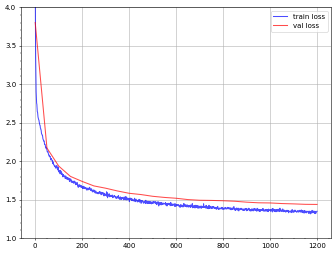

  0%|          | 0/1250 [00:00<?, ?it/s]

final loss: 1.355425477027893 final val loss: 1.4377106189727784


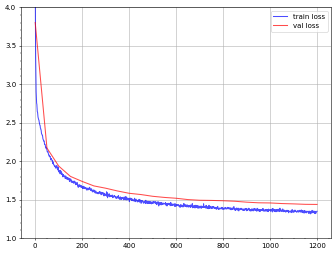

In [ ]:
# training!
model = TransformerLM(vocab_size, seq_len, 128, 2, 3)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
train(model, optimizer, seq_len, batch_size, total_steps)

In [ ]:
# Save
torch.save(model.state_dict(), 'TransformerLM.pt')

In [ ]:
# Load model
model = TransformerLM(vocab_size, seq_len, 128, 2, 3)
model.load_state_dict(torch.load('TransformerLM.pt'))
model.to(device)

TransformerLM(
  (token_embedding_table): Embedding(87, 128)
  (lm_head): Linear(in_features=128, out_features=87, bias=True)
  (blocks): ModuleList(
    (0-2): 3 x Block(
      (sa_heads): MultiHeadAttention(
        (heads): ModuleList(
          (0-1): 2 x SelfAttentionHead(
            (key): Linear(in_features=128, out_features=64, bias=False)
            (query): Linear(in_features=128, out_features=64, bias=False)
            (value): Linear(in_features=128, out_features=64, bias=False)
          )
        )
        (o): Linear(in_features=128, out_features=128, bias=True)
      )
      (ff_layer): FeedForward(
        (lin_1): Linear(in_features=128, out_features=512, bias=True)
        (lin_2): Linear(in_features=512, out_features=128, bias=True)
        (relu): ReLU()
      )
      (sa_norm): RMSNorm()
      (ff_norm): RMSNorm()
    )
  )
)

In [ ]:
model.eval()
idx = encode("You will never")
print(torch.tensor([idx]))
print(decode(model.generate(idx=torch.tensor([idx], dtype=torch.long).to(device), max_new_tokens=1000, temperature=0.5, use_cache=True)[0].tolist()))

tensor([[53, 72, 78,  1, 80, 66, 69, 69,  1, 71, 62, 79, 62, 75]])
You will never being a student from the chance of the guys face the chance of me.

The most of the eman arm.

In the new were a baby specialized a while consume than the same as a lot of our last summer have a study to do that.

Something that what you were supposed to course,

I want to go out of the power!

Where are you interesting some my heart is concerned to have to eat the woman.

It's the work out of the assume and feel to me to do is a thing something I do with you to have made you and smart of the uniter!

We're going to stop at the old out, aren't you on a chance!

And it's a huge she to the most of such a familiar considerate that she was at the father with and go along a dragon a place of destroyed that is a second stuff!

Maybe I was a lot of my father good some control the world.

The start can play it an all, but I'm sure it's going to a moment.

The past he would come for me to say the audisato.

What d

## Linear Transformer (Katharopoulos et al., 2020)

In [32]:
class LinearSelfAttentionHead(nn.Module):
    """ one head of self-attention """
    def __init__(self, seq_len, n_embd, head_size):
        super().__init__()
        self.seq_len = seq_len
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(seq_len, seq_len)))
        self.register_buffer('state_s', torch.zeros(head_size, head_size))
        self.register_buffer('state_z', torch.zeros(head_size))
        # use feature map = elu(x) + 1
        # self.phi = nn.ELU(inplace=True)
        # try softsign + 1
        self.phi = nn.Softsign()

    def reset_states(self):
        self.state_s.zero_()
        self.state_z.zero_()

    def forward(self, x, freqs_cis):
        B, T, C = x.shape
        is_training = T == self.seq_len
        q = self.query(x) # (B,T,C)
        q = self.phi(q) + 1
        k = self.key(x)   # (B,T,C)
        k = self.phi(k) + 1
        v = self.value(x) # (B,T,C)
        q, k = apply_rotary_emb(q, k, freqs_cis)

        # so linear attention is basically not using softmax so that you can swap the order of mmults
        if not is_training:
            # inference looks like this
            s0 = torch.einsum("btC, btc -> btCc", k, v) # (B, T, C, C)
            s = s0.sum(dim=1) # (B, C, C)
            self.state_s = self.state_s + s
            z = k.sum(dim=1) # (B, C)
            self.state_z = self.state_z + z
            if T > 1:
                n = torch.einsum("btc, btcC -> btC", q, s0.cumsum(dim=1)) # (B, T, C)
                m = torch.einsum("btc, btc -> bt", q, k.cumsum(dim=1)).unsqueeze(-1) # (B, T, 1)
            else:
                n = torch.einsum("btc, bcC -> btC", q, self.state_s) # (B, T, C)
                m = torch.einsum("btc, bc -> bt", q, self.state_z).unsqueeze(-1) # (B, T, 1)
            n = n / C**0.5 # scaled attention
            out = n / m # (B, T, C)
        else:
            # now this training part should be different based on the paper,
            # but idk yet how to implement it so let's try usual attention without softmax
            wei = q @ k.transpose(-2,-1) # (B, T, C) @ (B, C, T) -> (B, T, T)
            wei = self.tril[:T, :T] * wei # causal mask
            vbar = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
            vbar = vbar / C**0.5 # scaled attention
            out = vbar / wei.sum(dim=-1, keepdim=True) # (B, T, C) / (B, T, 1) -> (B, T, C) normalization like this??
        
        return out

class LinearMultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """
    def __init__(self, seq_len, num_heads, n_embd, head_size):
        super().__init__()
        self.heads = nn.ModuleList([LinearSelfAttentionHead(seq_len, n_embd, head_size) for _ in range(num_heads)])
        self.o = nn.Linear(num_heads*head_size, n_embd)

    def forward(self, x, freqs_cis):
        head_outs = [h(x, freqs_cis) for i, h in enumerate(self.heads)]
        out = torch.cat(head_outs, dim=-1) # concat single-head results
        out = self.o(out)
        return out

class LinearTransformerBlock(nn.Module):
    def __init__(self, seq_len, n_heads, n_embd):
        super().__init__()
        self.sa_heads = LinearMultiHeadAttention(seq_len, n_heads, n_embd, n_embd//n_heads)
        self.ff_layer = FeedForward(n_embd, n_embd*4)
        self.sa_norm = RMSNorm(n_embd, eps=1e-4)
        self.ff_norm = RMSNorm(n_embd, eps=1e-4)
    
    def forward(self, x, freqs_cis):
        h = x + self.sa_norm(self.sa_heads(x, freqs_cis))
        o = h + self.ff_norm(self.ff_layer(h))
        return o
    
class LinearTransformerLM(nn.Module):
    def __init__(self, vocab_size, seq_len, embed_size, head_num, layer_num):
        super().__init__()
        self.layer_num = layer_num
        self.head_num = head_num
        self.seq_len = seq_len
        # embed raw tokens to a lower dimensional embedding with embed_size
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        # Language Modelling (?) Head is a standard linear layer to go from 
        # embeddings back to logits of vocab_size
        self.lm_head = nn.Linear(embed_size, vocab_size)
        # transformer blocks
        self.blocks = nn.ModuleList([LinearTransformerBlock(seq_len, head_num, embed_size) for _ in range(layer_num)])
        # precompute frequencies for rotary embeddings
        self.freqs_cis = precompute_freqs_cis(embed_size//head_num, seq_len*2)

    def forward(self, idx, targets=None, T_past=None):
        B, T = idx.shape
        # idx and targets are both (B,T) tensor of integers
        tok_embd = self.token_embedding_table(idx) # (B,T,C)
        x = tok_embd
        # go through blocks
        freqs_cis = self.freqs_cis[:T] if T_past is None else self.freqs_cis[T_past:T_past+1]
        for i, block in enumerate(self.blocks):
            x = block(x, freqs_cis)
        # get logits with linear layer
        logits = self.lm_head(x) # (B,T,C)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, idx, max_new_tokens, temperature=1, reset_states=True):
        # reset states
        if reset_states:
            for block in self.blocks:
                for head in block.sa_heads.heads:
                    head.reset_states()
        # idx is (B, T) array of indices in the current context
        # crop idx to the last seq_len tokens
        idx_context = idx[:, -self.seq_len:]
        T = idx_context.shape[1]
        T_past = None
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx_context, T_past=T_past)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply temperature
            logits = logits / temperature if temperature > 0 else logits
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) if temperature > 0 else torch.argmax(probs, dim=-1, keepdim=True) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
            if T_past is None:
                T_past = T
            T_past += 1
            # since we have kv cache, only need to pass new token
            idx_context = idx_next
        return idx

        # # idx is (B, T) array of indices in the current context
        # for _ in range(max_new_tokens):
        #     #crop idx to the last seq_len tokens
        #     idx_context = idx[:, -self.seq_len:]
        #     # get the predictions
        #     logits, loss = self(idx_context)
        #     # focus only on the last time step
        #     logits = logits[:, -1, :] # becomes (B, C)
        #     # apply temperature
        #     logits = logits / temperature if temperature > 0 else logits
        #     # apply softmax to get probabilities
        #     probs = F.softmax(logits, dim=-1) # (B, C)
        #     # sample from the distribution
        #     idx_next = torch.multinomial(probs, num_samples=1) if temperature > 0 else torch.argmax(probs, dim=-1, keepdim=True) # (B, 1)
        #     # append sampled index to the running sequence
        #     idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        # return idx

In [33]:
# Test forward pass
m = LinearTransformerLM(vocab_size, seq_len, 128, 2, 3)
m.to(device)
xb, yb = get_batch('train', 5, 1)
logits, loss = m(xb)
total_params = sum(p.numel() for p in m.parameters() if p.requires_grad)
total_params

615255

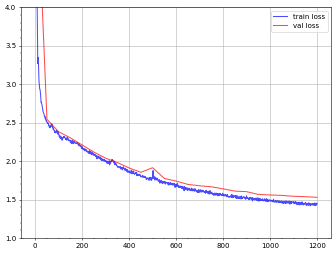

  0%|          | 0/1250 [00:00<?, ?it/s]

final loss: 1.4347203969955444 final val loss: 1.5300561308860778


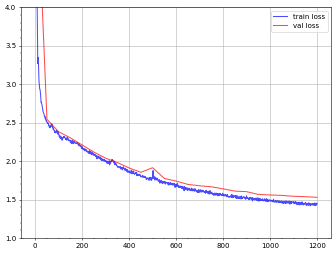

In [34]:
# training!
model = LinearTransformerLM(vocab_size, seq_len, 128, 2, 3)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
train(model, optimizer, seq_len, batch_size, total_steps)

In [27]:
# Save
torch.save(model.state_dict(), 'LinearTransformerLM.pt')

In [28]:
# Load model
model = LinearTransformerLM(vocab_size, seq_len, 128, 2, 3)
model.load_state_dict(torch.load('LinearTransformerLM.pt'))
model.to(device)

LinearTransformerLM(
  (token_embedding_table): Embedding(87, 128)
  (lm_head): Linear(in_features=128, out_features=87, bias=True)
  (blocks): ModuleList(
    (0-2): 3 x LinearTransformerBlock(
      (sa_heads): LinearMultiHeadAttention(
        (heads): ModuleList(
          (0-1): 2 x LinearSelfAttentionHead(
            (key): Linear(in_features=128, out_features=64, bias=False)
            (query): Linear(in_features=128, out_features=64, bias=False)
            (value): Linear(in_features=128, out_features=64, bias=False)
            (phi): ELU(alpha=1.0, inplace=True)
          )
        )
        (o): Linear(in_features=128, out_features=128, bias=True)
      )
      (ff_layer): FeedForward(
        (lin_1): Linear(in_features=128, out_features=512, bias=True)
        (lin_2): Linear(in_features=512, out_features=128, bias=True)
        (relu): ReLU()
      )
      (sa_norm): RMSNorm()
      (ff_norm): RMSNorm()
    )
  )
)

In [35]:
model.eval()
idx = encode("You will never")
print(torch.tensor([idx]))
print(decode(model.generate(idx=torch.tensor([idx], dtype=torch.long).to(device), max_new_tokens=200, temperature=0.7)[0].tolist()))

tensor([[53, 72, 78,  1, 80, 66, 69, 69,  1, 71, 62, 79, 62, 75]])
You will never better has long as I guess it'll be a dream.

experience for something of her to the magic allege nergy our kin shere didented memorent ingroue.


I n asppid! Thowa, Sord o some.


I I's -Sto.




Wh


# SSMs